1. Скачиваем репозиторий lime (и добавляем его в .gitignore)
git clone https://github.com/marcotcr/lime.git

2. Устанавливаем lime, pandas

In [5]:
!pip3 install lime pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 140.3 kB/s eta 0:00:0000:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 kB 130.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 493.4 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: pip3 install --upgrade pip


3. Выполнить импорт библиотек и модулей. Выполняем задание по определению пикселей

Text(0.5, 1.0, 'Digit: 5')

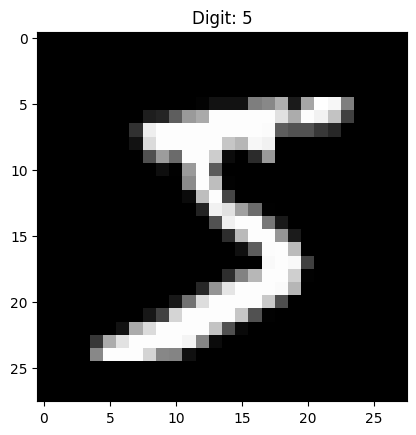

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb

from sklearn.datasets import fetch_openml

### SSL CERTIFICATE error fix
import requests
requests.packages.urllib3.disable_warnings()
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context


mnist = fetch_openml('mnist_784')
X_vec = np.stack([gray2rgb(iimg) for iimg in mnist.data.values.astype(np.uint8).reshape((-1, 28, 28))],0).astype(np.uint8)
y_vec = mnist.target.astype(np.uint8)

%matplotlib inline
fig, ax1 = plt.subplots(1,1)
ax1.imshow(X_vec[0], interpolation = 'none')
ax1.set_title('Digit: {}'.format(y_vec[0]))

4. Работаем по jupyter-notebook с https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20MNIST%20and%20RF.ipynb

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer

class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)


makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    #('Normalize', Normalizer()),
    #('PCA', PCA(16)),
    ('RF', RandomForestClassifier())
                              ])

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec,
                                                    train_size=0.55)

In [9]:
simple_rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x17e3c1710>),
                ('Flatten Image', <__main__.PipeStep object at 0x17f069810>),
                ('RF', RandomForestClassifier())])

In [10]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime

In [11]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
%%time
explanation = explainer.explain_instance(X_test[0], 
                                         classifier_fn = simple_rf_pipeline.predict_proba, 
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

100%|██████████| 10000/10000 [00:01<00:00, 6327.50it/s]


CPU times: user 1.87 s, sys: 29.6 ms, total: 1.9 s
Wall time: 1.65 s


Text(0.5, 1.0, 'Positive/Negative Regions for 2')

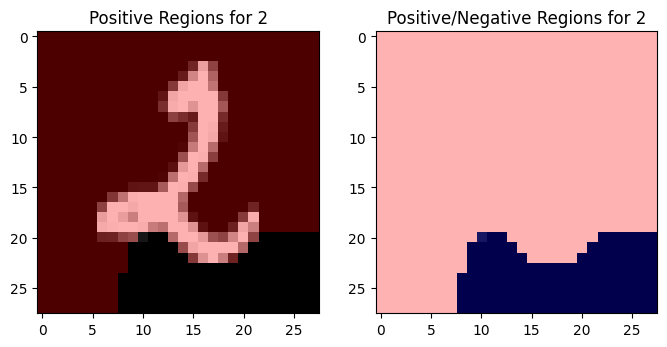

In [14]:
temp, mask = explanation.get_image_and_mask(y_test.iloc[0], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test.iloc[0]))
temp, mask = explanation.get_image_and_mask(y_test.iloc[0], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test.iloc[0]))

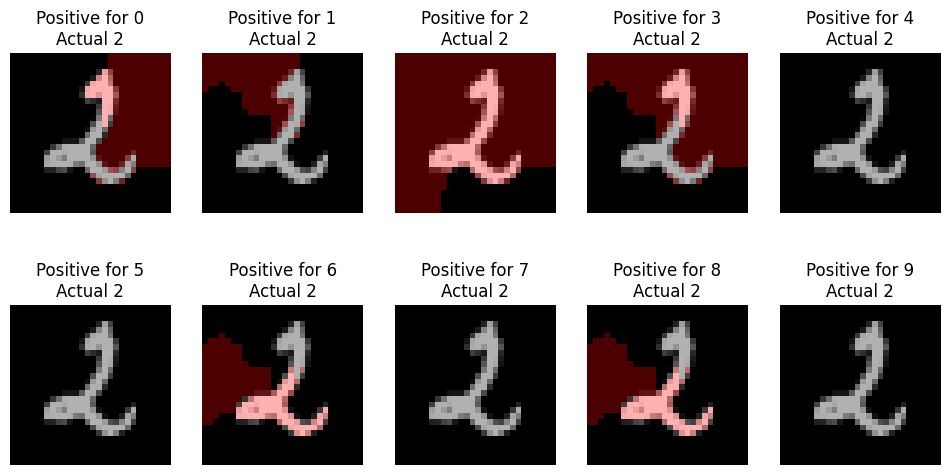

In [16]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,X_test[0], bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test.iloc[0]))
    c_ax.axis('off')

In [21]:
pipe_pred_test = simple_rf_pipeline.predict(X_test)
wrong_idx = np.random.choice(np.where(pipe_pred_test!=y_test)[0])
print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test[wrong_idx], pipe_pred_test[wrong_idx]))

Using #21369 where the label was 9 and the pipeline predicted 2


In [22]:
%%time
explanation = explainer.explain_instance(X_test[wrong_idx],
                                         classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)
     

100%|██████████| 10000/10000 [00:01<00:00, 6200.59it/s]

CPU times: user 1.92 s, sys: 26.2 ms, total: 1.94 s
Wall time: 1.67 s


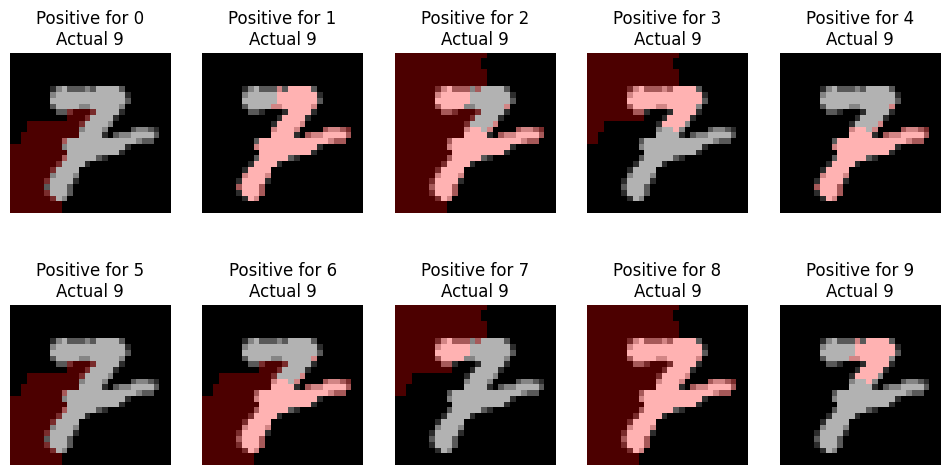

In [23]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[wrong_idx]))
    c_ax.axis('off')